In [62]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import datasets

#from dstools import data_tools


# for plotting
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import graphviz
import pydotplus

import matplotlib.pylab as plt
%matplotlib inline
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 14, 10

In [63]:
url = "https://raw.githubusercontent.com/fivethirtyeight/data/master/nba-elo/nbaallelo.csv"


nba = pd.read_csv(url)

In [64]:
new_name_list = ["Game Number", "ID", "League", "Repeat", "Year", "Game Date", "Season Game Number", "Playoffs", "Team Abv", "Franchise", "Points", "Elo_Start", "Elo End", "Win Equiv", "Opp Abv", "Opp Franchise", "Opp Score", "Opp_Elo_Start", "Opp Elo End", "Game Location", "Game Result", "Forecast", "Notes"]

nba.columns = new_name_list

In [65]:
nba.dtypes

Game Number             int64
ID                     object
League                 object
Repeat                  int64
Year                    int64
Game Date              object
Season Game Number      int64
Playoffs                int64
Team Abv               object
Franchise              object
Points                  int64
Elo_Start             float64
Elo End               float64
Win Equiv             float64
Opp Abv                object
Opp Franchise          object
Opp Score               int64
Opp_Elo_Start         float64
Opp Elo End           float64
Game Location          object
Game Result            object
Forecast              float64
Notes                  object
dtype: object

In [66]:
nba = nba[["Year", "Game Date", "Franchise", "Elo_Start","Opp Franchise", "Opp_Elo_Start", "Game Location", "Game Result"]]
nba = nba[nba["Year"]>=2012].copy()

In [67]:
nba["Elo Difference"] = nba.Elo_Start - nba.Opp_Elo_Start

In [68]:
nba['Game Date'] = pd.to_datetime(nba['Game Date'])
nba.head(5)

,Year,Game Date,Franchise,Elo_Start,Opp Franchise,Opp_Elo_Start,Game Location,Game Result,Elo Difference
116278,2012,2011-12-25,Heat,1652.3988,Mavericks,1678.1997,A,W,-25.8009
116279,2012,2011-12-25,Mavericks,1678.1997,Heat,1652.3988,H,L,25.8009
116280,2012,2011-12-25,Clippers,1454.1561,Warriors,1493.6945,A,W,-39.5384
116281,2012,2011-12-25,Warriors,1493.6945,Clippers,1454.1561,H,L,39.5384
116282,2012,2011-12-25,Lakers,1594.3787,Bulls,1632.1742,H,L,-37.7955


In [69]:
# converting H and A into 1 and 0 for mapping

nba["Game Location"] = nba["Game Location"].str.replace("A","1")
nba["Game Location"] = nba["Game Location"].str.replace("H","0")

# 1 is home
# 0 is away 

In [70]:
homecourt = nba[nba["Game Location"] == "1"].copy()

In [71]:
homecourt.head(5)

,Year,Game Date,Franchise,Elo_Start,Opp Franchise,Opp_Elo_Start,Game Location,Game Result,Elo Difference
116278,2012,2011-12-25,Heat,1652.3988,Mavericks,1678.1997,1,W,-25.8009
116280,2012,2011-12-25,Clippers,1454.1561,Warriors,1493.6945,1,W,-39.5384
116283,2012,2011-12-25,Bulls,1632.1742,Lakers,1594.3787,1,W,37.7955
116284,2012,2011-12-25,Celtics,1596.1472,Knicks,1482.5021,1,L,113.6451
116286,2012,2011-12-25,Magic,1582.5724,Thunder,1620.4620,1,L,-37.8896


In [72]:
upsetwins = homecourt[homecourt["Game Result"] == "W"].copy()

In [73]:
upsetwins.head(5)

,Year,Game Date,Franchise,Elo_Start,Opp Franchise,Opp_Elo_Start,Game Location,Game Result,Elo Difference
116278,2012,2011-12-25,Heat,1652.3988,Mavericks,1678.1997,1,W,-25.8009
116280,2012,2011-12-25,Clippers,1454.1561,Warriors,1493.6945,1,W,-39.5384
116283,2012,2011-12-25,Bulls,1632.1742,Lakers,1594.3787,1,W,37.7955
116291,2012,2011-12-26,Raptors,1350.1757,Cavaliers,1369.9215,1,W,-19.7458
116292,2012,2011-12-26,Nuggets,1590.4297,Mavericks,1661.7070,1,W,-71.2773


In [79]:
upsetwins = upsetwins[upsetwins["Elo Difference"] < 0]
homecourt = homecourt[homecourt["Elo Difference"] < 0]

In [80]:
upsetwins.head(5)

,Year,Game Date,Franchise,Elo_Start,Opp Franchise,Opp_Elo_Start,Game Location,Game Result,Elo Difference
116278,2012,2011-12-25,Heat,1652.3988,Mavericks,1678.1997,1,W,-25.8009
116280,2012,2011-12-25,Clippers,1454.1561,Warriors,1493.6945,1,W,-39.5384
116291,2012,2011-12-26,Raptors,1350.1757,Cavaliers,1369.9215,1,W,-19.7458
116292,2012,2011-12-26,Nuggets,1590.4297,Mavericks,1661.7070,1,W,-71.2773
116311,2012,2011-12-26,Nets,1352.2601,Wizards,1371.3854,1,W,-19.1253


In [81]:
grp = upsetwins.groupby("Franchise")
homecourt_grp = homecourt.groupby("Franchise")
#This is good stuff. Groupby function essentially lets you split the dataframe into small dataframes within the larger data which
#you can call to do operations. So here I split the dataframe into each franchise which lets us not double count games and 
#minimize how much processing we need to use per team

In [82]:
grp.get_group("Bucks")

# so here im pulling the Bucks data specifically. May be worth paring the data down into 2000 onward 

,Year,Game Date,Franchise,Elo_Start,Opp Franchise,Opp_Elo_Start,Game Location,Game Result,Elo Difference
116718,2012,2012-01-20,Bucks,1454.7029,Knicks,1473.4457,1,W,-18.7428
116754,2012,2012-01-22,Bucks,1473.5911,Heat,1671.9220,1,W,-198.3309
116801,2012,2012-01-25,Bucks,1487.1237,Rockets,1563.0255,1,W,-75.9018
117566,2012,2012-03-16,Bucks,1482.9812,Warriors,1509.2937,1,W,-26.3125
118455,2013,2012-11-02,Bucks,1501.1670,Celtics,1586.1121,1,W,-84.9451
118621,2013,2012-11-12,Bucks,1508.5000,Sixers,1551.6627,1,W,-43.1627
118818,2013,2012-11-26,Bucks,1512.1105,Bulls,1571.4832,1,W,-59.3727
119184,2013,2012-12-21,Bucks,1491.0122,Celtics,1538.3230,1,W,-47.3108
119458,2013,2013-01-09,Bucks,1479.9662,Bulls,1554.3053,1,W,-74.3391
120113,2013,2013-02-26,Bucks,1451.3185,Mavericks,1505.0323,1,W,-53.7138


In [83]:
Bucks = grp.get_group("Bucks")

In [84]:
def date_diff(Bucks):
    Bucks["Game Diff"] = Bucks["Game Date"].diff()
    return Bucks

#made a function to calculate the difference in games. Have to use .diff() for the individual teams. Can import this function into
# something bigger to go team by team

In [85]:
date_diff(Bucks)

# The function. The date difference is in the end of the dataframe

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Year,Game Date,Franchise,Elo_Start,Opp Franchise,Opp_Elo_Start,Game Location,Game Result,Elo Difference,Game Diff
116718,2012,2012-01-20,Bucks,1454.7029,Knicks,1473.4457,1,W,-18.7428,NaT
116754,2012,2012-01-22,Bucks,1473.5911,Heat,1671.9220,1,W,-198.3309,2 days
116801,2012,2012-01-25,Bucks,1487.1237,Rockets,1563.0255,1,W,-75.9018,3 days
117566,2012,2012-03-16,Bucks,1482.9812,Warriors,1509.2937,1,W,-26.3125,51 days
118455,2013,2012-11-02,Bucks,1501.1670,Celtics,1586.1121,1,W,-84.9451,231 days
118621,2013,2012-11-12,Bucks,1508.5000,Sixers,1551.6627,1,W,-43.1627,10 days
118818,2013,2012-11-26,Bucks,1512.1105,Bulls,1571.4832,1,W,-59.3727,14 days
119184,2013,2012-12-21,Bucks,1491.0122,Celtics,1538.3230,1,W,-47.3108,25 days
119458,2013,2013-01-09,Bucks,1479.9662,Bulls,1554.3053,1,W,-74.3391,19 days
120113,2013,2013-02-26,Bucks,1451.3185,Mavericks,1505.0323,1,W,-53.7138,48 days


In [86]:
grp.apply(date_diff)

# Here im applying the function to the whole table by franchise. May try to clean this up and see what it looks like to see which
# method is the easiest. 

,Year,Game Date,Franchise,Elo_Start,Opp Franchise,Opp_Elo_Start,Game Location,Game Result,Elo Difference,Game Diff
116278,2012,2011-12-25,Heat,1652.3988,Mavericks,1678.1997,1,W,-25.8009,NaT
116280,2012,2011-12-25,Clippers,1454.1561,Warriors,1493.6945,1,W,-39.5384,NaT
116291,2012,2011-12-26,Raptors,1350.1757,Cavaliers,1369.9215,1,W,-19.7458,NaT
116292,2012,2011-12-26,Nuggets,1590.4297,Mavericks,1661.7070,1,W,-71.2773,NaT
116311,2012,2011-12-26,Nets,1352.2601,Wizards,1371.3854,1,W,-19.1253,NaT
116328,2012,2011-12-28,Cavaliers,1356.5503,Pistons,1417.2306,1,W,-60.6803,NaT
116372,2012,2011-12-30,Suns,1469.5493,Pelicans,1521.4115,1,W,-51.8622,NaT
116416,2012,2012-01-02,Hawks,1511.9998,Heat,1681.2399,1,W,-169.2401,NaT
116422,2012,2012-01-02,Raptors,1353.4785,Knicks,1494.7676,1,W,-141.2891,7 days
116436,2012,2012-01-03,Trailblazers,1551.2844,Thunder,1631.7677,1,W,-80.4833,NaT


In [87]:
nba.head(5)

,Year,Game Date,Franchise,Elo_Start,Opp Franchise,Opp_Elo_Start,Game Location,Game Result,Elo Difference
116278,2012,2011-12-25,Heat,1652.3988,Mavericks,1678.1997,1,W,-25.8009
116279,2012,2011-12-25,Mavericks,1678.1997,Heat,1652.3988,0,L,25.8009
116280,2012,2011-12-25,Clippers,1454.1561,Warriors,1493.6945,1,W,-39.5384
116281,2012,2011-12-25,Warriors,1493.6945,Clippers,1454.1561,0,L,39.5384
116282,2012,2011-12-25,Lakers,1594.3787,Bulls,1632.1742,0,L,-37.7955


In [88]:
Bucks.count()

Year              28
Game Date         28
Franchise         28
Elo_Start         28
Opp Franchise     28
Opp_Elo_Start     28
Game Location     28
Game Result       28
Elo Difference    28
Game Diff         27
dtype: int64

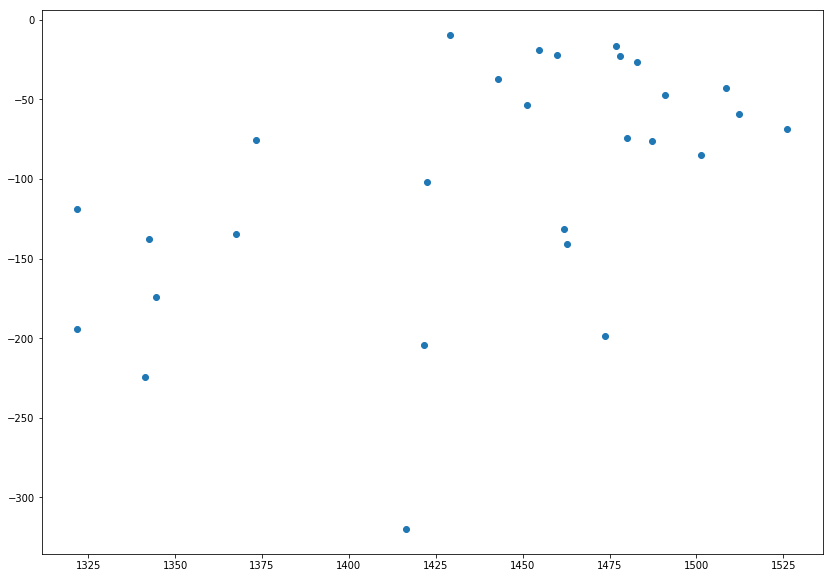

In [89]:
plt.scatter(x=Bucks['Elo_Start'] ,y=Bucks['Elo Difference'])

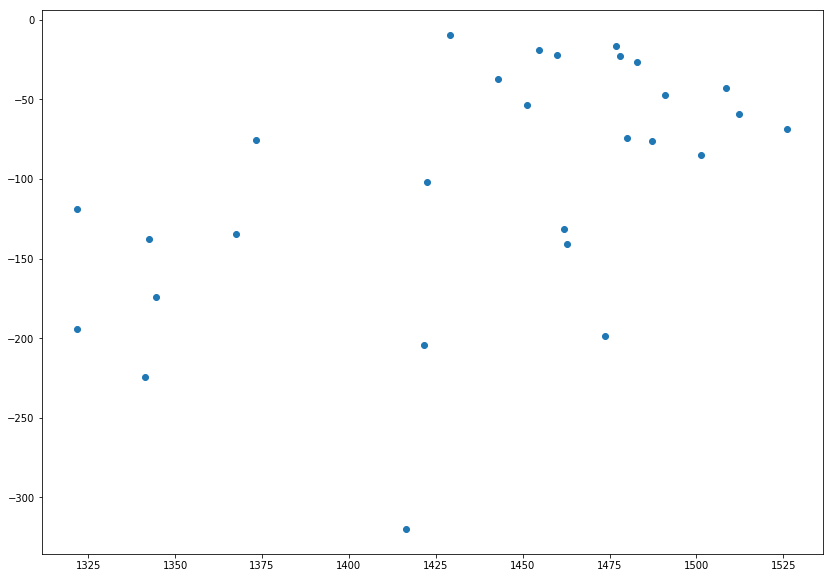

In [90]:
import seaborn as sns
plt.scatter(x ='Elo_Start' ,y ='Elo Difference', data = Bucks)

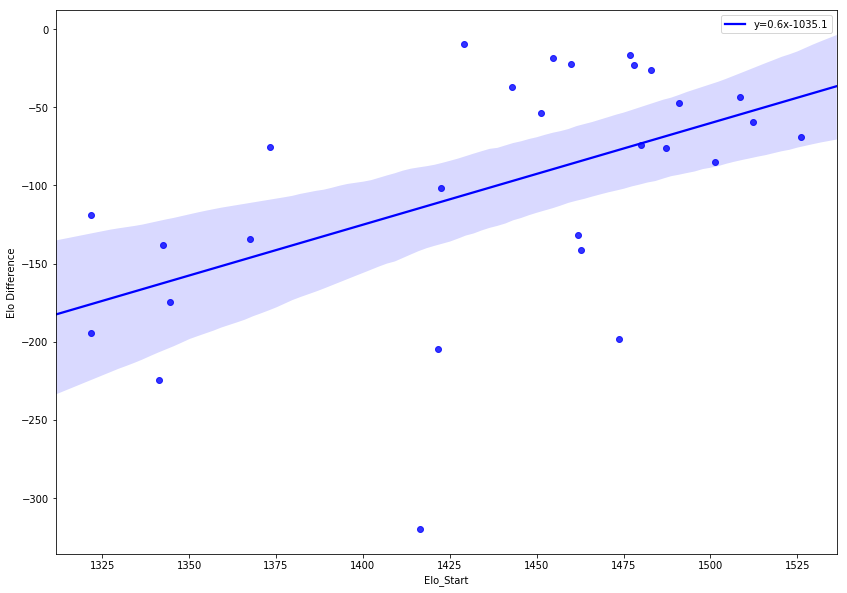

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(Bucks['Elo_Start'],Bucks['Elo Difference'])

# use line_kws to set line label for legend
ax = sns.regplot(x="Elo_Start", y="Elo Difference", data= Bucks, color='b', 
 line_kws={'label':"y={0:.1f}x{1:.1f}".format(slope,intercept)})

# plot legend
ax.legend()

plt.show()

In [92]:

def Plot_Data(data, v1, v2, tv):
    # Make the plot square
    plt.rcParams['figure.figsize'] = [50, 300]
    
    # Color
    color = ["red" if x == 0 else "blue" for x in data[tv]]
    
    # Plot and label
    plt.scatter(data[v1], data[v2], c=color, s=50)
    plt.xlabel(v1)
    plt.ylabel(v2)
    plt.xlim([min(data[v1]) , max(data[v1]) ])
    plt.ylim([min(data[v2]) , max(data[v2]) ])
    

In [93]:
# We can see that the Bucks simply do not have a large amount of home upsets, especially since many of their wins come from
# when they were ranked below the skill of an average team. Now we are going to test on a team known for home court, the Nuggets

In [94]:
Nuggets = grp.get_group("Nuggets")

In [95]:
Nuggets.head(5)
Nuggets.count()

Year              17
Game Date         17
Franchise         17
Elo_Start         17
Opp Franchise     17
Opp_Elo_Start     17
Game Location     17
Game Result       17
Elo Difference    17
dtype: int64

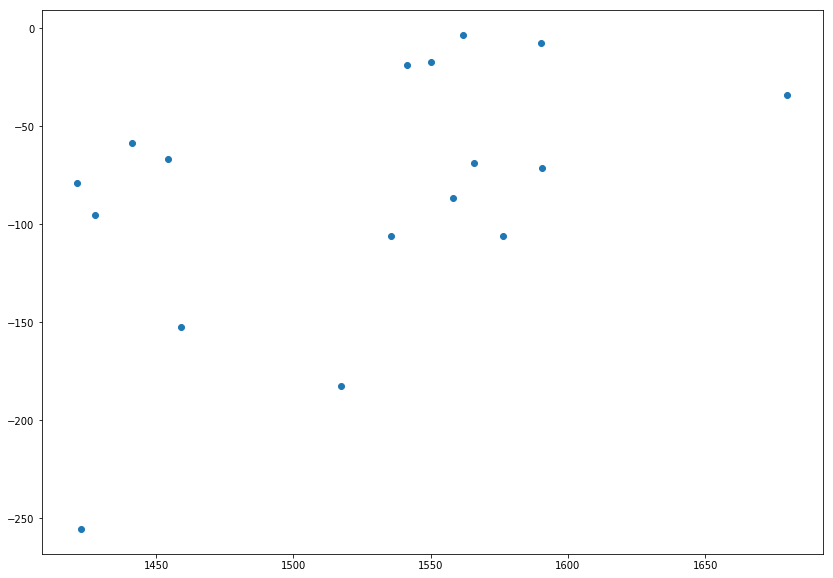

In [96]:
plt.scatter(x=Nuggets['Elo_Start'] ,y=Nuggets['Elo Difference'])

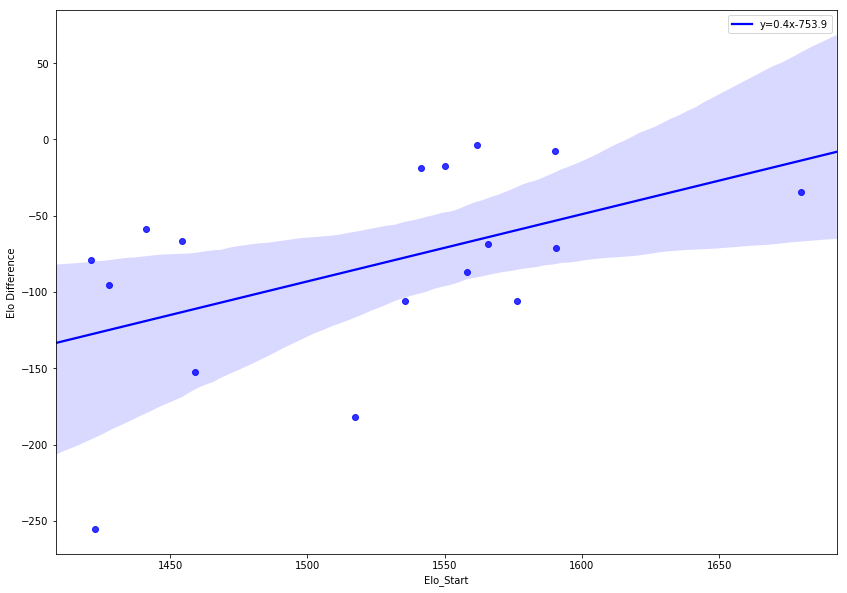

In [97]:
# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(Nuggets['Elo_Start'],Nuggets['Elo Difference'])

# use line_kws to set line label for legend
ax = sns.regplot(x="Elo_Start", y="Elo Difference", data= Nuggets, color='b', 
 line_kws={'label':"y={0:.1f}x{1:.1f}".format(slope,intercept)})

# plot legend
ax.legend()

plt.show()

In [98]:
BucksHome = homecourt_grp.get_group("Bucks")

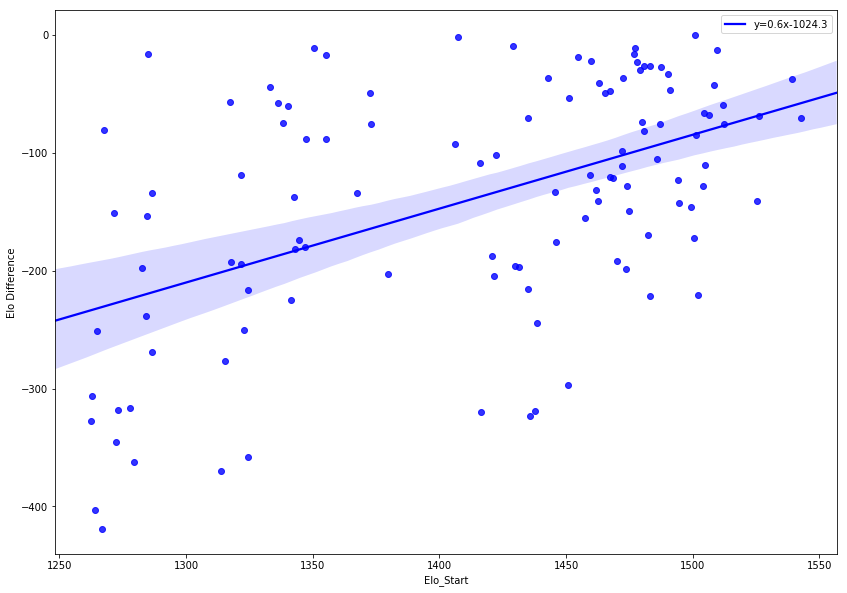

In [99]:
# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(BucksHome['Elo_Start'],BucksHome['Elo Difference'])

# use line_kws to set line label for legend
ax = sns.regplot(x="Elo_Start", y="Elo Difference", data= BucksHome, color='b', 
 line_kws={'label':"y={0:.1f}x{1:.1f}".format(slope,intercept)})

# plot legend
ax.legend()

plt.show()